# Performance Prediction Under Dataset Shift

Comparison of different types of Performance Predictors under dataset shift.

Results of paper "Performance Prediction Under Dataset Shift"

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import pickle
from drift_dac_experiments.viz_utils import name2type
import matplotlib.patches as mpatches
from scipy import stats

In [3]:
datasets = [
        'adult',
        'video_games',
        'heart',
        'bank',
        'dont_get_kicked',
        'Churn_Modelling',
        'bng_zoo',
        'jsbach_chorals_modified',
        'SDSS',
        'bng_ionosphere',
        'network_intrusion_detection',
        'artificial_characters',
        'default_of_credit_card_clients'
    ]

Load results

In [30]:
datasets = datasets[:3]

In [31]:
df = pd.DataFrame(columns=['dataset', 'ref. accuracy', 'CI'])
df_test_no_shift = pd.DataFrame()
df_test = pd.DataFrame()
df_test_unseen = pd.DataFrame()
df_test_unseen_subpop = pd.DataFrame()
df_test_natural = pd.DataFrame()

sets = ['train', 'test', 'test_no_shift', 'test_unseen', 'test_unseen_subpop', 'test_natural']

for i, ds in enumerate(datasets):
    
    data_fld = ds
    pp_fld = ds + '_pp'
    
    print(data_fld.upper())
    
    try:
    
        all_ref_accuracies = []
        all_ci_drops = []
        for seed in range(10):
            with open(os.path.join(data_fld, './data_%d.pkl' % seed), 'rb') as f:
                train, test, test_unseen, test_natural, ref_task, _ = pickle.load(f)

            with open(os.path.join(data_fld, './shifts_%d.pkl' % seed), 'rb') as f:
                list_of_drift_types, filtered_list_of_train_shifts, filtered_list_of_test_shifts, filtered_list_of_unseen_shifts = pickle.load(f)

            train_shifts_names = [name2type(s) for s in filtered_list_of_train_shifts]
            test_shifts_names = [name2type(s) for s in filtered_list_of_test_shifts]

            ref_accuracy = ref_task.ref_accuracy

            alpha = 0.05
            n_samples = ref_task.y_src.shape[0]
            sigma = np.sqrt(ref_accuracy * (1 - ref_accuracy) / n_samples)
            ci_drop = stats.norm.ppf(1 - alpha / 2) * sigma

            all_ref_accuracies.append(ref_accuracy)
            all_ci_drops.append(ci_drop)


        new_row = {
         "dataset": data_fld,
         "ref. accuracy": '%.3f \tiny{$\pm$%.3f}' % (np.mean(all_ref_accuracies), np.std(all_ref_accuracies)),
         "CI": '%.3f \tiny{$\pm$%.3f}' % (np.mean(all_ci_drops), np.std(all_ci_drops))
          }
        df = df.append(new_row, ignore_index=True)
        
        with open(os.path.join(pp_fld, './model_names.npy'), 'rb') as f:
            model_names = np.load(f)

        for j, s in enumerate(sets):

            with open(os.path.join(pp_fld, './r2_score_%s.npy'%s), 'rb') as f:
                r2_score = np.load(f)

            with open(os.path.join(pp_fld, './within_ci_mae_%s.npy'%s), 'rb') as f:
                within_ci_mae = np.load(f)

            with open(os.path.join(pp_fld, './likelihood_%s.npy'%s), 'rb') as f:
                likelihood = np.load(f)

            for i, name in enumerate(model_names):
                new_row = {"dataset": ds, 'model': name}

                new_row['mae_within_ci'] = '%.3f \tiny{$\pm$ %.3f}' % (np.mean(within_ci_mae[:, i]), np.std(within_ci_mae[:, i]))

                if s=='test':
                    df_test = df_test.append(new_row, ignore_index=True)
                elif s=='test_no_shift':
                    df_test_no_shift = df_test_no_shift.append(new_row, ignore_index=True)
                elif s=='test_unseen':
                    df_test_unseen = df_test_unseen.append(new_row, ignore_index=True)
                elif s=='test_unseen_subpop':
                    df_test_unseen_subpop = df_test_unseen_subpop.append(new_row, ignore_index=True)
                elif s=='test_natural':
                    df_test_natural = df_test_natural.append(new_row, ignore_index=True)
                    
    except Exception as e:
        print(e)
        print("SKIP")
        continue
        

ADULT
VIDEO_GAMES
HEART


DataFrame with datasets accuracies and confidence intervals

In [32]:
df

,dataset,ref. accuracy,CI
0,adult,0.826 \tiny{$\pm$0.016},0.033 \tiny{$\pm$0.001}
1,video_games,0.798 \tiny{$\pm$0.019},0.036 \tiny{$\pm$0.001}
2,heart,0.706 \tiny{$\pm$0.015},0.028 \tiny{$\pm$0.000}


In [33]:
print(df.to_latex(index=False).replace('textbackslash ','').replace('\$','$').replace('\{','{').replace('\}', '}'))

\begin{tabular}{lll}
\toprule
     dataset &            ref. accuracy &                       CI \\
\midrule
       adult &  0.826 \tiny{$\pm$0.016} &  0.033 \tiny{$\pm$0.001} \\
 video\_games &  0.798 \tiny{$\pm$0.019} &  0.036 \tiny{$\pm$0.001} \\
       heart &  0.706 \tiny{$\pm$0.015} &  0.028 \tiny{$\pm$0.000} \\
\bottomrule
\end{tabular}



DataFrame with MAE_CI_0.05 results for test_no_shift for all datasets

In [34]:
selected_models = ['ATC', 'ExpertRF (amazon)', 'ExpertRF (naver)', 'ErrorPredictorRF']

In [35]:
d = df_test_no_shift[df_test_no_shift['model'].isin(selected_models)].set_index(['dataset', 'model']).stack().unstack([1,2])
d = d[selected_models]
d = d.iloc[d.index.str.lower().argsort()]
d

model,ATC,ExpertRF (amazon),ExpertRF (naver),ErrorPredictorRF
,mae_within_ci,mae_within_ci,mae_within_ci,mae_within_ci
dataset,,,,
adult,0.000 \tiny{$\pm$ 0.000},0.035 \tiny{$\pm$ 0.057},0.030 \tiny{$\pm$ 0.049},0.000 \tiny{$\pm$ 0.000}
heart,0.003 \tiny{$\pm$ 0.005},0.061 \tiny{$\pm$ 0.058},0.059 \tiny{$\pm$ 0.054},0.003 \tiny{$\pm$ 0.006}
video_games,0.003 \tiny{$\pm$ 0.007},0.022 \tiny{$\pm$ 0.021},0.019 \tiny{$\pm$ 0.017},0.005 \tiny{$\pm$ 0.007}


In [36]:
print(d.to_latex().replace('textbackslash ','').replace('\$','$').replace('\{','{').replace('\}', '}'))

\begin{tabular}{lllll}
\toprule
model &                       ATC &         ExpertRF (amazon) &          ExpertRF (naver) &          ErrorPredictorRF \\
{} &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci \\
dataset     &                           &                           &                           &                           \\
\midrule
adult       &  0.000 \tiny{$\pm$ 0.000} &  0.035 \tiny{$\pm$ 0.057} &  0.030 \tiny{$\pm$ 0.049} &  0.000 \tiny{$\pm$ 0.000} \\
heart       &  0.003 \tiny{$\pm$ 0.005} &  0.061 \tiny{$\pm$ 0.058} &  0.059 \tiny{$\pm$ 0.054} &  0.003 \tiny{$\pm$ 0.006} \\
video\_games &  0.003 \tiny{$\pm$ 0.007} &  0.022 \tiny{$\pm$ 0.021} &  0.019 \tiny{$\pm$ 0.017} &  0.005 \tiny{$\pm$ 0.007} \\
\bottomrule
\end{tabular}



DataFrame with MAE_CI_0.05 results for test_unseen_severity for all datasets

In [37]:
d = df_test[df_test['model'].isin(selected_models)].set_index(['dataset', 'model']).stack().unstack([1,2])
d = d[selected_models]
d = d.iloc[d.index.str.lower().argsort()]
d

model,ATC,ExpertRF (amazon),ExpertRF (naver),ErrorPredictorRF
,mae_within_ci,mae_within_ci,mae_within_ci,mae_within_ci
dataset,,,,
adult,0.023 \tiny{$\pm$ 0.018},0.019 \tiny{$\pm$ 0.027},0.017 \tiny{$\pm$ 0.030},0.006 \tiny{$\pm$ 0.009}
heart,0.050 \tiny{$\pm$ 0.038},0.042 \tiny{$\pm$ 0.034},0.034 \tiny{$\pm$ 0.028},0.017 \tiny{$\pm$ 0.020}
video_games,0.052 \tiny{$\pm$ 0.031},0.010 \tiny{$\pm$ 0.013},0.011 \tiny{$\pm$ 0.014},0.016 \tiny{$\pm$ 0.012}


In [38]:
print(d.to_latex().replace('textbackslash ','').replace('\$','$').replace('\{','{').replace('\}', '}'))

\begin{tabular}{lllll}
\toprule
model &                       ATC &         ExpertRF (amazon) &          ExpertRF (naver) &          ErrorPredictorRF \\
{} &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci \\
dataset     &                           &                           &                           &                           \\
\midrule
adult       &  0.023 \tiny{$\pm$ 0.018} &  0.019 \tiny{$\pm$ 0.027} &  0.017 \tiny{$\pm$ 0.030} &  0.006 \tiny{$\pm$ 0.009} \\
heart       &  0.050 \tiny{$\pm$ 0.038} &  0.042 \tiny{$\pm$ 0.034} &  0.034 \tiny{$\pm$ 0.028} &  0.017 \tiny{$\pm$ 0.020} \\
video\_games &  0.052 \tiny{$\pm$ 0.031} &  0.010 \tiny{$\pm$ 0.013} &  0.011 \tiny{$\pm$ 0.014} &  0.016 \tiny{$\pm$ 0.012} \\
\bottomrule
\end{tabular}



DataFrame with MAE_CI_0.05 results for test_unseen_perturbation_shift for all datasets

In [39]:
d = df_test_unseen[df_test_unseen['model'].isin(selected_models)].set_index(['dataset', 'model']).stack().unstack([1,2])
d = d[selected_models]
d = d.iloc[d.index.str.lower().argsort()]
d

model,ATC,ExpertRF (amazon),ExpertRF (naver),ErrorPredictorRF
,mae_within_ci,mae_within_ci,mae_within_ci,mae_within_ci
dataset,,,,
adult,0.026 \tiny{$\pm$ 0.017},0.026 \tiny{$\pm$ 0.029},0.013 \tiny{$\pm$ 0.013},0.011 \tiny{$\pm$ 0.012}
heart,0.073 \tiny{$\pm$ 0.048},0.045 \tiny{$\pm$ 0.035},0.043 \tiny{$\pm$ 0.021},0.014 \tiny{$\pm$ 0.020}
video_games,0.045 \tiny{$\pm$ 0.030},0.013 \tiny{$\pm$ 0.011},0.012 \tiny{$\pm$ 0.009},0.006 \tiny{$\pm$ 0.004}


In [40]:
print(d.to_latex().replace('textbackslash ','').replace('\$','$').replace('\{','{').replace('\}', '}'))

\begin{tabular}{lllll}
\toprule
model &                       ATC &         ExpertRF (amazon) &          ExpertRF (naver) &          ErrorPredictorRF \\
{} &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci \\
dataset     &                           &                           &                           &                           \\
\midrule
adult       &  0.026 \tiny{$\pm$ 0.017} &  0.026 \tiny{$\pm$ 0.029} &  0.013 \tiny{$\pm$ 0.013} &  0.011 \tiny{$\pm$ 0.012} \\
heart       &  0.073 \tiny{$\pm$ 0.048} &  0.045 \tiny{$\pm$ 0.035} &  0.043 \tiny{$\pm$ 0.021} &  0.014 \tiny{$\pm$ 0.020} \\
video\_games &  0.045 \tiny{$\pm$ 0.030} &  0.013 \tiny{$\pm$ 0.011} &  0.012 \tiny{$\pm$ 0.009} &  0.006 \tiny{$\pm$ 0.004} \\
\bottomrule
\end{tabular}



DataFrame with MAE_CI_0.05 results for test_unseen_subpop_shift for all datasets

In [41]:
d = df_test_unseen_subpop[df_test_unseen_subpop['model'].isin(selected_models)].set_index(['dataset', 'model']).stack().unstack([1,2])
d = d[selected_models]
d = d.iloc[d.index.str.lower().argsort()]
d


model,ATC,ExpertRF (amazon),ExpertRF (naver),ErrorPredictorRF
,mae_within_ci,mae_within_ci,mae_within_ci,mae_within_ci
dataset,,,,
adult,0.024 \tiny{$\pm$ 0.017},0.046 \tiny{$\pm$ 0.013},0.038 \tiny{$\pm$ 0.015},0.035 \tiny{$\pm$ 0.019}
heart,0.019 \tiny{$\pm$ 0.023},0.087 \tiny{$\pm$ 0.049},0.075 \tiny{$\pm$ 0.044},0.016 \tiny{$\pm$ 0.011}
video_games,0.038 \tiny{$\pm$ 0.010},0.056 \tiny{$\pm$ 0.022},0.052 \tiny{$\pm$ 0.019},0.032 \tiny{$\pm$ 0.016}


In [42]:
print(d.to_latex().replace('textbackslash ','').replace('\$','$').replace('\{','{').replace('\}', '}'))

\begin{tabular}{lllll}
\toprule
model &                       ATC &         ExpertRF (amazon) &          ExpertRF (naver) &          ErrorPredictorRF \\
{} &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci \\
dataset     &                           &                           &                           &                           \\
\midrule
adult       &  0.024 \tiny{$\pm$ 0.017} &  0.046 \tiny{$\pm$ 0.013} &  0.038 \tiny{$\pm$ 0.015} &  0.035 \tiny{$\pm$ 0.019} \\
heart       &  0.019 \tiny{$\pm$ 0.023} &  0.087 \tiny{$\pm$ 0.049} &  0.075 \tiny{$\pm$ 0.044} &  0.016 \tiny{$\pm$ 0.011} \\
video\_games &  0.038 \tiny{$\pm$ 0.010} &  0.056 \tiny{$\pm$ 0.022} &  0.052 \tiny{$\pm$ 0.019} &  0.032 \tiny{$\pm$ 0.016} \\
\bottomrule
\end{tabular}



DataFrame with MAE_CI_0.05 results for test_natural for all datasets

In [43]:
d = df_test_natural[df_test_natural['model'].isin(selected_models)].set_index(['dataset', 'model']).stack().unstack([1,2])
d = d[selected_models]
d = d.iloc[d.index.str.lower().argsort()]
d

model,ATC,ExpertRF (amazon),ExpertRF (naver),ErrorPredictorRF
,mae_within_ci,mae_within_ci,mae_within_ci,mae_within_ci
dataset,,,,
adult,0.006 \tiny{$\pm$ 0.006},0.070 \tiny{$\pm$ 0.037},0.056 \tiny{$\pm$ 0.026},0.003 \tiny{$\pm$ 0.007}
heart,0.002 \tiny{$\pm$ 0.006},0.061 \tiny{$\pm$ 0.053},0.050 \tiny{$\pm$ 0.038},0.010 \tiny{$\pm$ 0.015}
video_games,0.029 \tiny{$\pm$ 0.014},0.035 \tiny{$\pm$ 0.019},0.036 \tiny{$\pm$ 0.020},0.009 \tiny{$\pm$ 0.005}


In [44]:
print(d.to_latex().replace('textbackslash ','').replace('\$','$').replace('\{','{').replace('\}', '}'))

\begin{tabular}{lllll}
\toprule
model &                       ATC &         ExpertRF (amazon) &          ExpertRF (naver) &          ErrorPredictorRF \\
{} &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci &             mae\_within\_ci \\
dataset     &                           &                           &                           &                           \\
\midrule
adult       &  0.006 \tiny{$\pm$ 0.006} &  0.070 \tiny{$\pm$ 0.037} &  0.056 \tiny{$\pm$ 0.026} &  0.003 \tiny{$\pm$ 0.007} \\
heart       &  0.002 \tiny{$\pm$ 0.006} &  0.061 \tiny{$\pm$ 0.053} &  0.050 \tiny{$\pm$ 0.038} &  0.010 \tiny{$\pm$ 0.015} \\
video\_games &  0.029 \tiny{$\pm$ 0.014} &  0.035 \tiny{$\pm$ 0.019} &  0.036 \tiny{$\pm$ 0.020} &  0.009 \tiny{$\pm$ 0.005} \\
\bottomrule
\end{tabular}



Show all results plots

In [45]:
suffixes = ['paper2', 'errpred']

In [46]:
figsize = (12, 12)

In [47]:
plt.rcParams.update({'font.size': 18})

ADULT


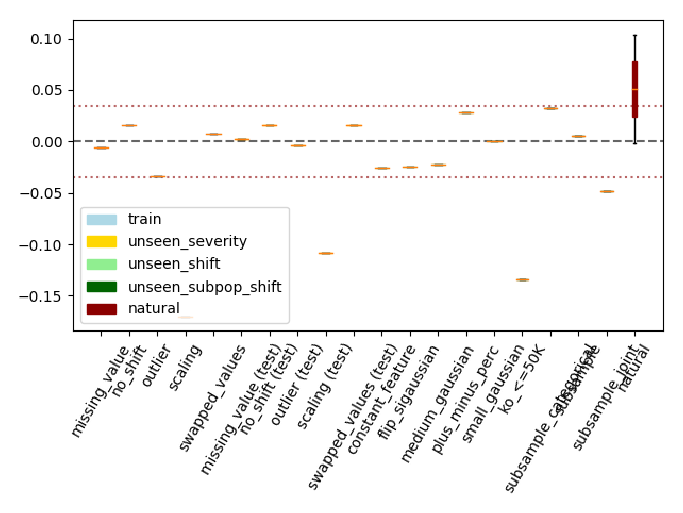

---- adult - paper2


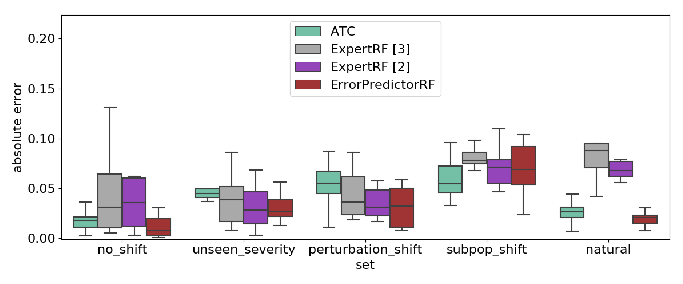

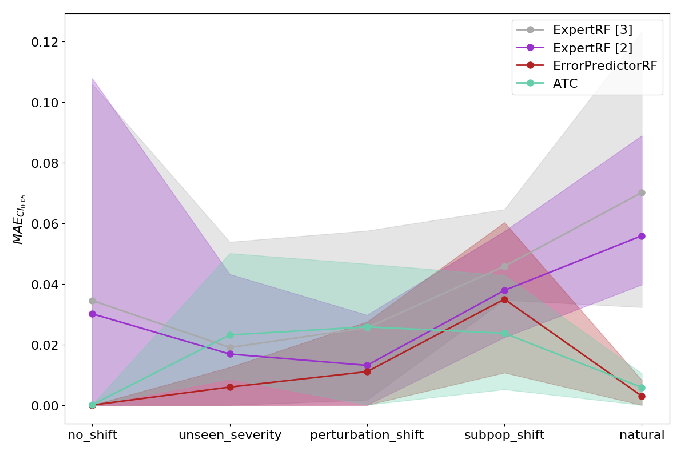

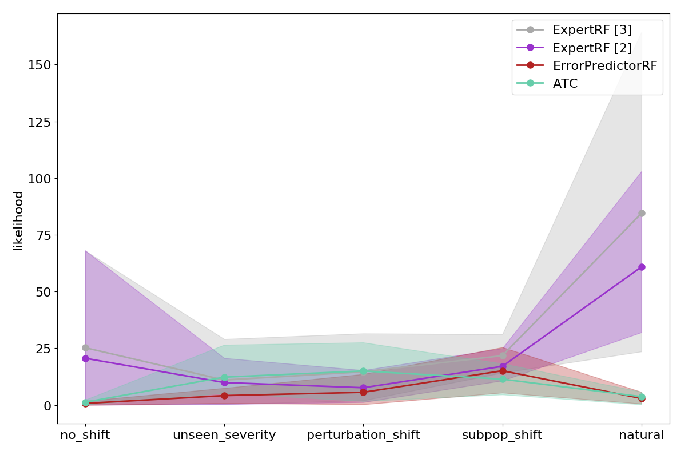

---- adult - errpred


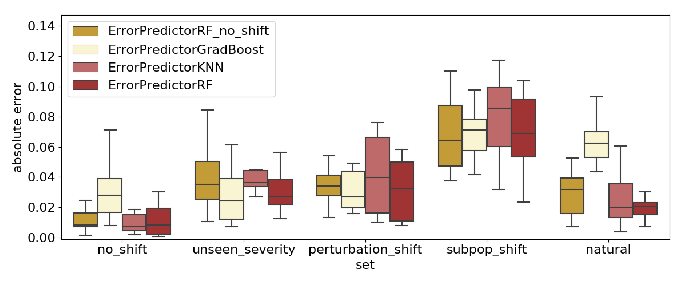

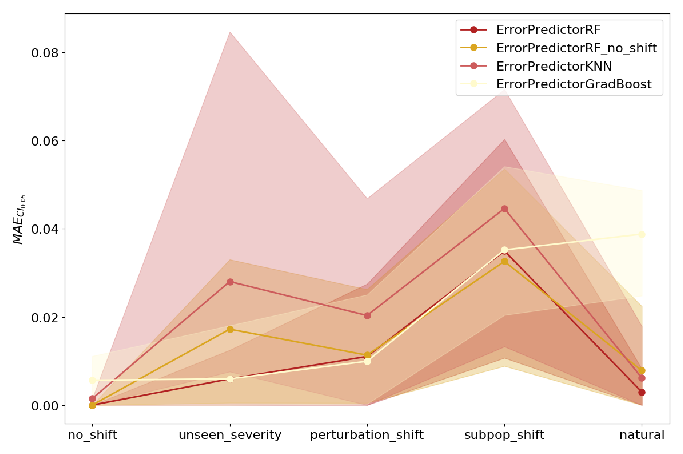

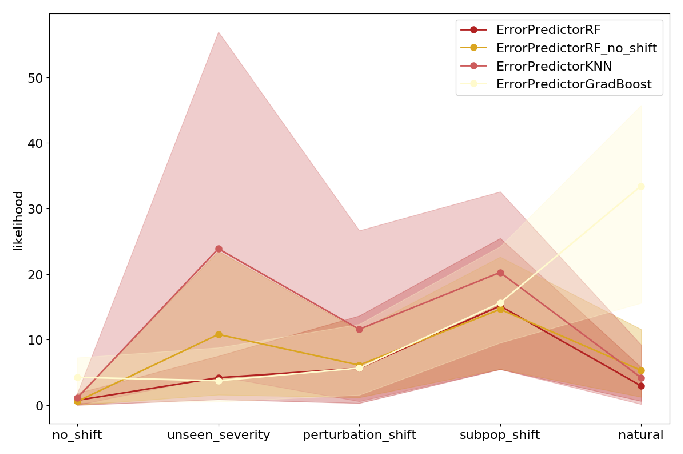

VIDEO_GAMES


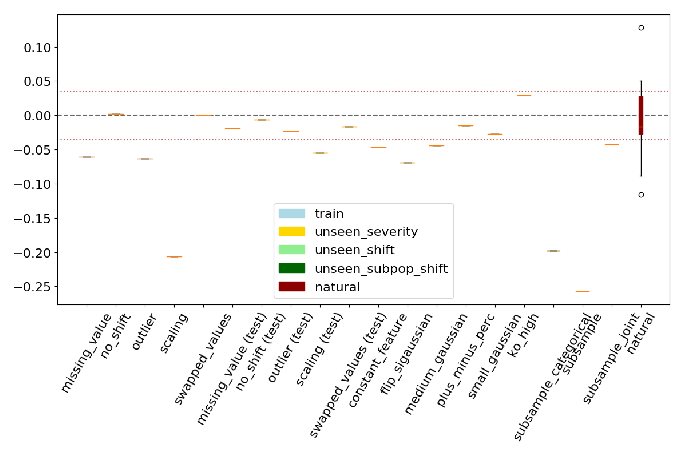

---- video_games - paper2


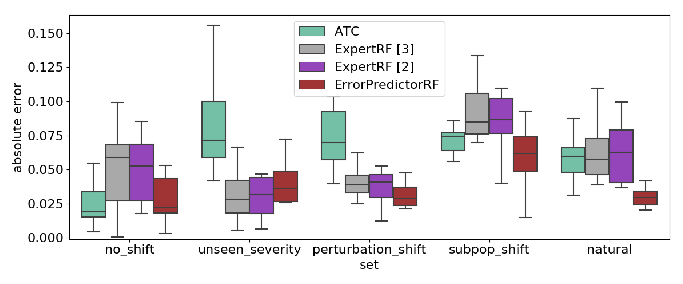

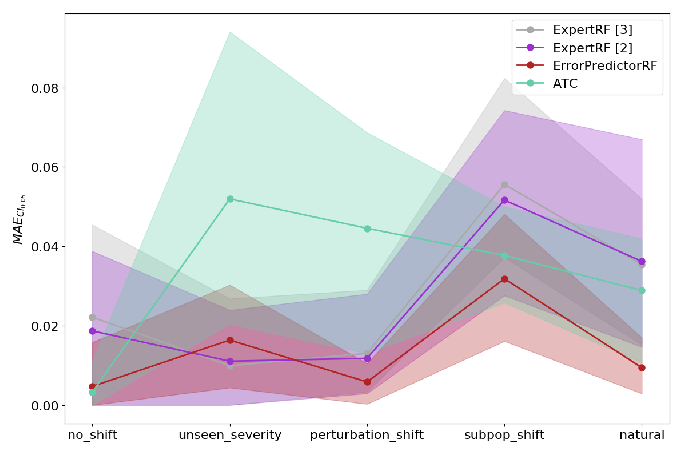

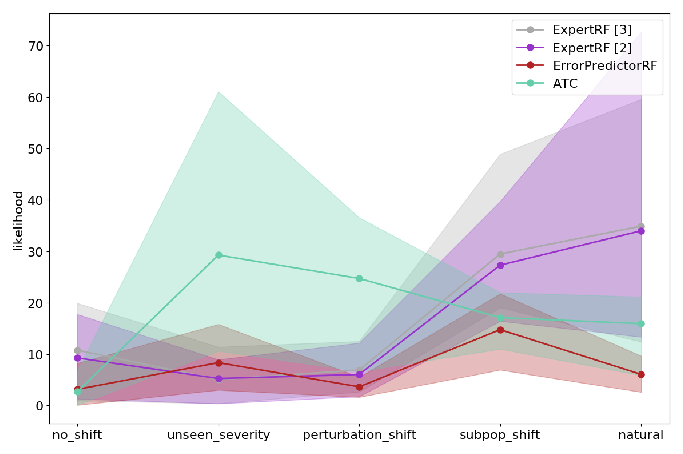

---- video_games - errpred


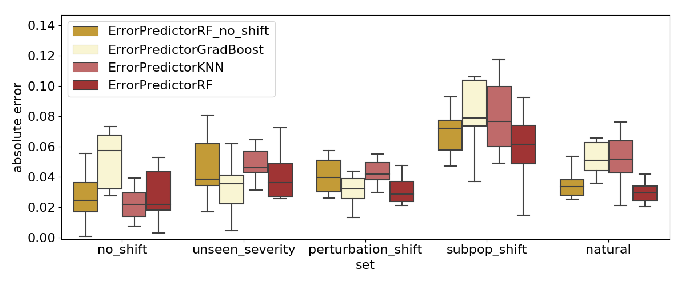

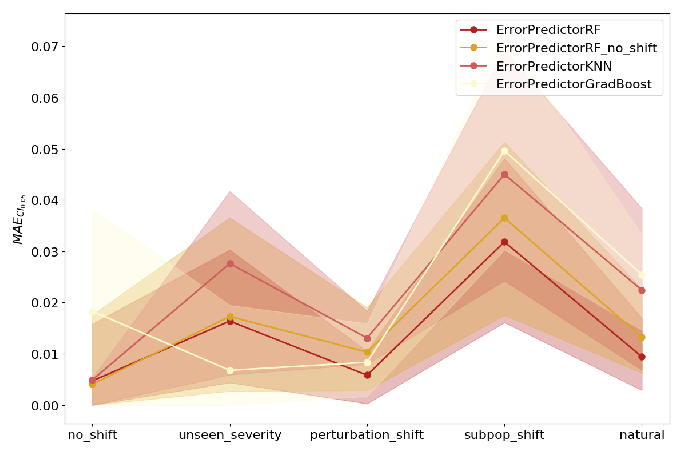

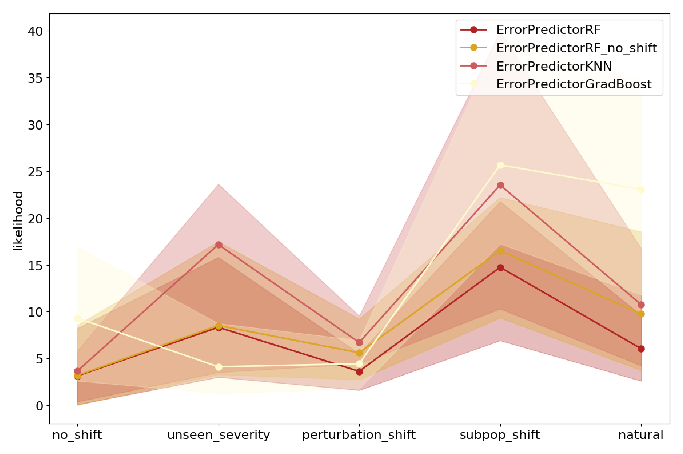

HEART


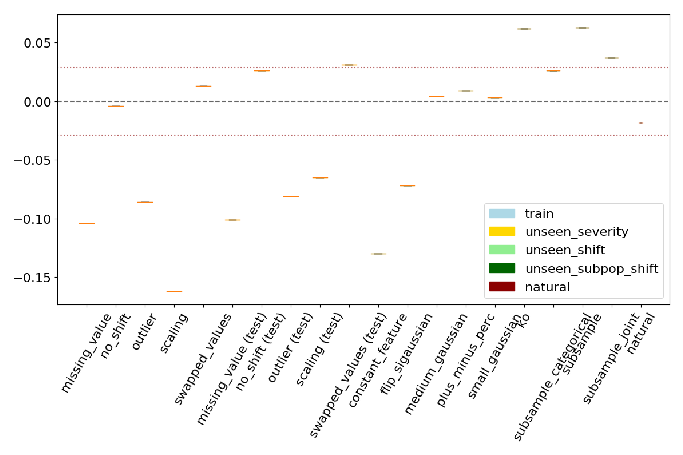

---- heart - paper2


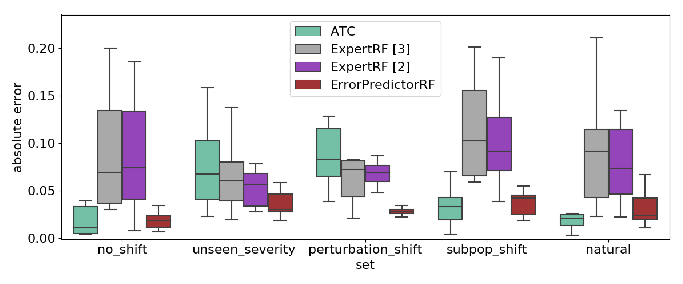

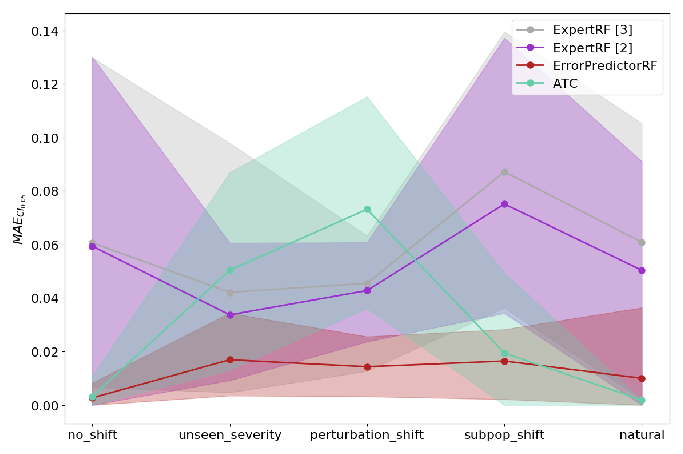

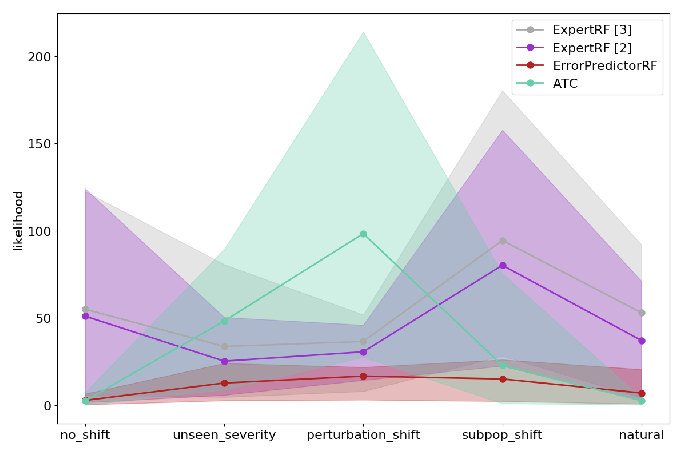

---- heart - errpred


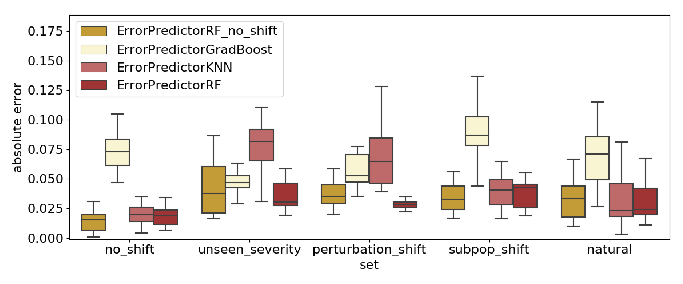

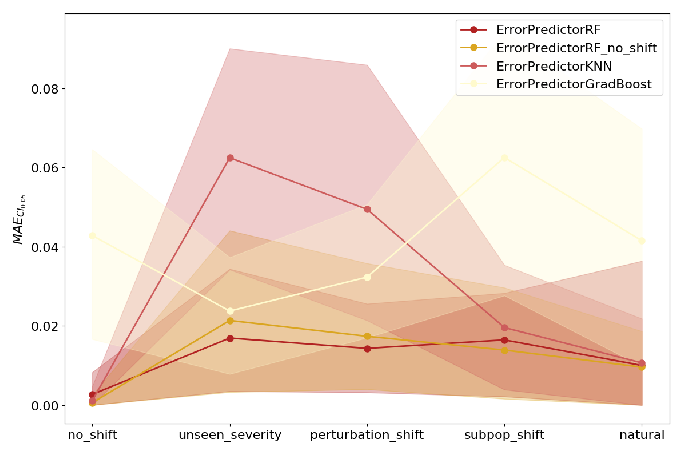

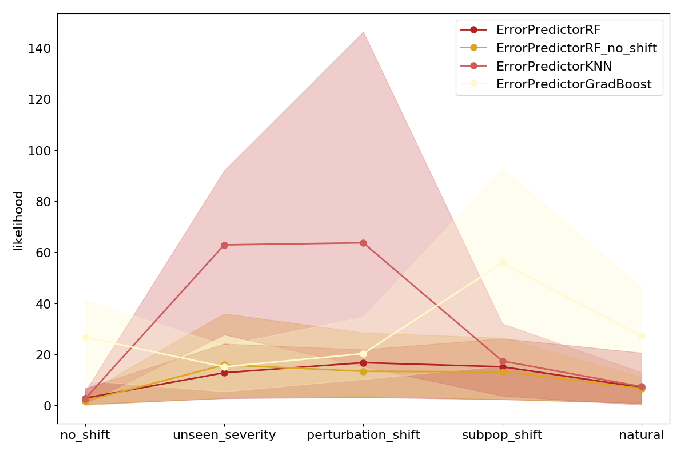

In [48]:
for i, ds in enumerate(datasets):
    
    data_fld = ds
    viz_fld = ds + '_viz'
    
    print(ds.upper())
    
    try:
    
        plt.figure(figsize = figsize)
        x = plt.imread(os.path.join(data_fld, 'true_drops_by_type_0.png'))
        plt.imshow(x)
        plt.axis('off')
        plt.show()

        for suffix in suffixes:
            print('---- ' + ds + ' - ' + suffix)

            plt.figure(figsize = figsize)
            x = plt.imread(os.path.join(viz_fld, 'abs_error_' + suffix + '.png'))
            plt.imshow(x)
            plt.axis('off')
            plt.show()

            plt.figure(figsize = figsize)
            x = plt.imread(os.path.join(viz_fld, 'within_ci_mae_' + suffix + '.png'))
            plt.imshow(x)
            plt.axis('off')
            plt.show()

            plt.figure(figsize = figsize)
            x = plt.imread(os.path.join(viz_fld, 'likelihood_' + suffix + '.png'))
            plt.imshow(x)
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(e)
        continue
    